# Bibliotecas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Dataframe dos resultados

In [5]:
path = "/home/lucas/experimentos/Teste_usando_14_head_e_MSE_loss/version_0/metrics.csv"

df = pd.read_csv(path)
df

,loss,epoch,step,val_loss
0,0.056892,0,49,NaN
1,0.068476,0,99,NaN
2,0.047275,0,149,NaN
3,0.082731,0,199,NaN
4,0.058538,0,249,NaN
...,...,...,...,...
171,0.045567,10,8099,NaN
172,0.033826,10,8149,NaN
173,0.075766,10,8199,NaN
174,0.069247,10,8249,NaN


# 2. Obtendo a loss de treino e de validacao

## 2.1 Validacao

In [61]:
#df_val_loss = df[df['val_loss'].apply(lambda x: pd.notna(x))].copy()
df_val_loss = df[["epoch","val_loss"]].copy()
df_val_loss.rename({"val_loss":"loss"},inplace=True,axis=1)
df_val_loss["Split"] = "Validação"

df_val_loss = df_val_loss[df_val_loss.loss.apply(lambda x: pd.notna(x))]
df_val_loss

,epoch,loss,Split
15,0,0.059446,Validação
31,1,0.057568,Validação
47,2,0.057523,Validação
63,3,0.056286,Validação
79,4,0.056646,Validação
95,5,0.054975,Validação
111,6,0.056382,Validação
127,7,0.055840,Validação
143,8,0.055574,Validação
159,9,0.055127,Validação


## 2.2 Treino

In [62]:
#index_val = df_val_loss.index.tolist()

#index_val = [x - 1 for x in index_val]
#df_train_loss = df.loc[index_val].copy()
df_train_loss = df[["epoch","loss"]].copy()

df_train_loss["Split"] = "Treino"
df_train_loss

,epoch,loss,Split
0,0,0.056892,Treino
1,0,0.068476,Treino
2,0,0.047275,Treino
3,0,0.082731,Treino
4,0,0.058538,Treino
...,...,...,...
171,10,0.045567,Treino
172,10,0.033826,Treino
173,10,0.075766,Treino
174,10,0.069247,Treino


# 3. Grafico comparativo de Loss

In [63]:
df_concat = pd.concat([df_train_loss,df_val_loss])

<Axes: xlabel='epoch', ylabel='loss'>

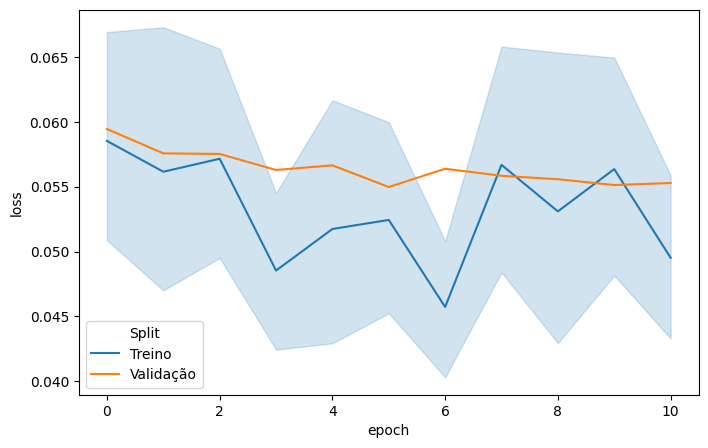

In [64]:
fig, ax = plt.subplots(figsize=(8,5))

sns.lineplot(data=df_concat,x="epoch",y="loss",hue="Split",ax=ax)

#sns.lineplot(data=df,x="epoch",y="loss",ax=ax)
#sns.lineplot(data=df,x="epoch",y="val_loss",ax=ax)

In [1]:
import sys
sys.path.append("/home/lucas/Image-Denoising/src")


import pandas as pd
from PIL import Image
from tqdm import tqdm

from model import VisionModel
from noises import add_noise
from dataset import CustomImageDataset


import torch
from torch import nn
from torch.utils.data import DataLoader
from utils.light_module import LightningVisionTransformer
from torchvision.transforms import v2

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch import Trainer

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:


class AddNoise(torch.nn.Module):
    def forward(self, img, noise,**kwargs):
        noisy_image = add_noise(img, noise_type=noise,**kwargs)

        return Image.fromarray(noisy_image)

if __name__ == '__main__':
    batch_size = 2
    num_workers = 8
    lr = 0.001
    epochs = 64
    patience = 5
    #dir_path_checkpoint = "/home/lucas/experimentos/"
    name_exp = "Teste_usando_14_head_e_MSE_loss"
    dir_save_logs = "/home/lucas/experimentos/"
    #prefix = "mse_head_14"
    name_to_save = "checkpoint-{epoch:02d}-{val_loss:.2f}"
    top_k = 1

    noise = AddNoise()
    transform = v2.Compose([
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True)
    ])
    
    path = "/home/lucas/datasets/dataframe_v1.csv"
    df = pd.read_csv(path)

    train = df[df["split"] == 'train']
    test = df[df["split"] == 'test']
    val = df[df["split"] == 'val']

    train_dataset = CustomImageDataset(train,transform,noise)
    test_dataset = CustomImageDataset(test,transform,noise)
    val_dataset = CustomImageDataset(val,transform,noise)

    
    custom_dataloader_train = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True)
    
    custom_dataloader_val = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False)
    
    custom_dataloader_test = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False)
    
    model = VisionModel(
        img_size=(batch_size,3,224,224),
        patch_size=14,
        #patch_size=28,
        token_len=512,
        num_layers=12,
        num_heads=16
    )
    
    #model = model.cuda()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    #model = model_.cpu()
    model_ = LightningVisionTransformer(model,loss_fn,optimizer)

/home/lucas/miniconda3/envs/image-denoising/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
model_.device

device(type='cpu')

In [8]:
model = model_.model

In [2]:
torch.load(
    "/home/lucas/experimentos/Teste_usando_14_head_e_MSE_loss/version_0/checkpoint-epoch=05-val_loss=0.05.ckpt")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 10.91 GiB of which 19.25 MiB is free. Process 639706 has 9.94 GiB memory in use. Including non-PyTorch memory, this process has 964.00 MiB memory in use. Of the allocated memory 804.08 MiB is allocated by PyTorch, and 23.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
model.load_state_dict()

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 10.91 GiB of which 19.25 MiB is free. Process 639706 has 9.94 GiB memory in use. Including non-PyTorch memory, this process has 964.00 MiB memory in use. Of the allocated memory 806.58 MiB is allocated by PyTorch, and 21.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [3]:
model_ = model_.load_from_checkpoint(
    )

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 10.91 GiB of which 19.25 MiB is free. Process 639706 has 9.94 GiB memory in use. Including non-PyTorch memory, this process has 964.00 MiB memory in use. Of the allocated memory 804.08 MiB is allocated by PyTorch, and 23.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF